# Libraries and Imp Function

In [1]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd=r"C:\Program Files\Tesseract-OCR\tesseract.exe"
import cv2
import numpy as np
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
import string
from nltk.tokenize import word_tokenize
import re
from textblob import TextBlob

#### Image display function using matplotlib

In [2]:
def display(im_data):
    dpi = 80
    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [3]:
def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

#### Gettin the angle at which the image is skewed

In [4]:
def getSkewAngle(cvImage) -> float:
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=4)
    display(dilate)
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    
    # Determining the angle.
    angle = minAreaRect[-1]
    print(angle)
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

#### Rotate the image around its center

In [5]:
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

#### Deskew image

In [6]:
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

# Image Pre-processing

In [7]:
image_file = r"images\012.jpg"
img = cv2.imread(image_file)

In [8]:
def remove_top_lines_from_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(25,1))
    dilate = cv2.dilate(binary,kernel,iterations=1)
    display(dilate)
    contours = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    contour = sorted(contours, key = lambda x: cv2.boundingRect(x)[0])
    for c in contour:
        x, y, w, h = cv2.boundingRect(c)
        if y < 100 and h < img.shape[0]//4 and w > img.shape[1]//2:
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), -1)  # Black out the region
    return img

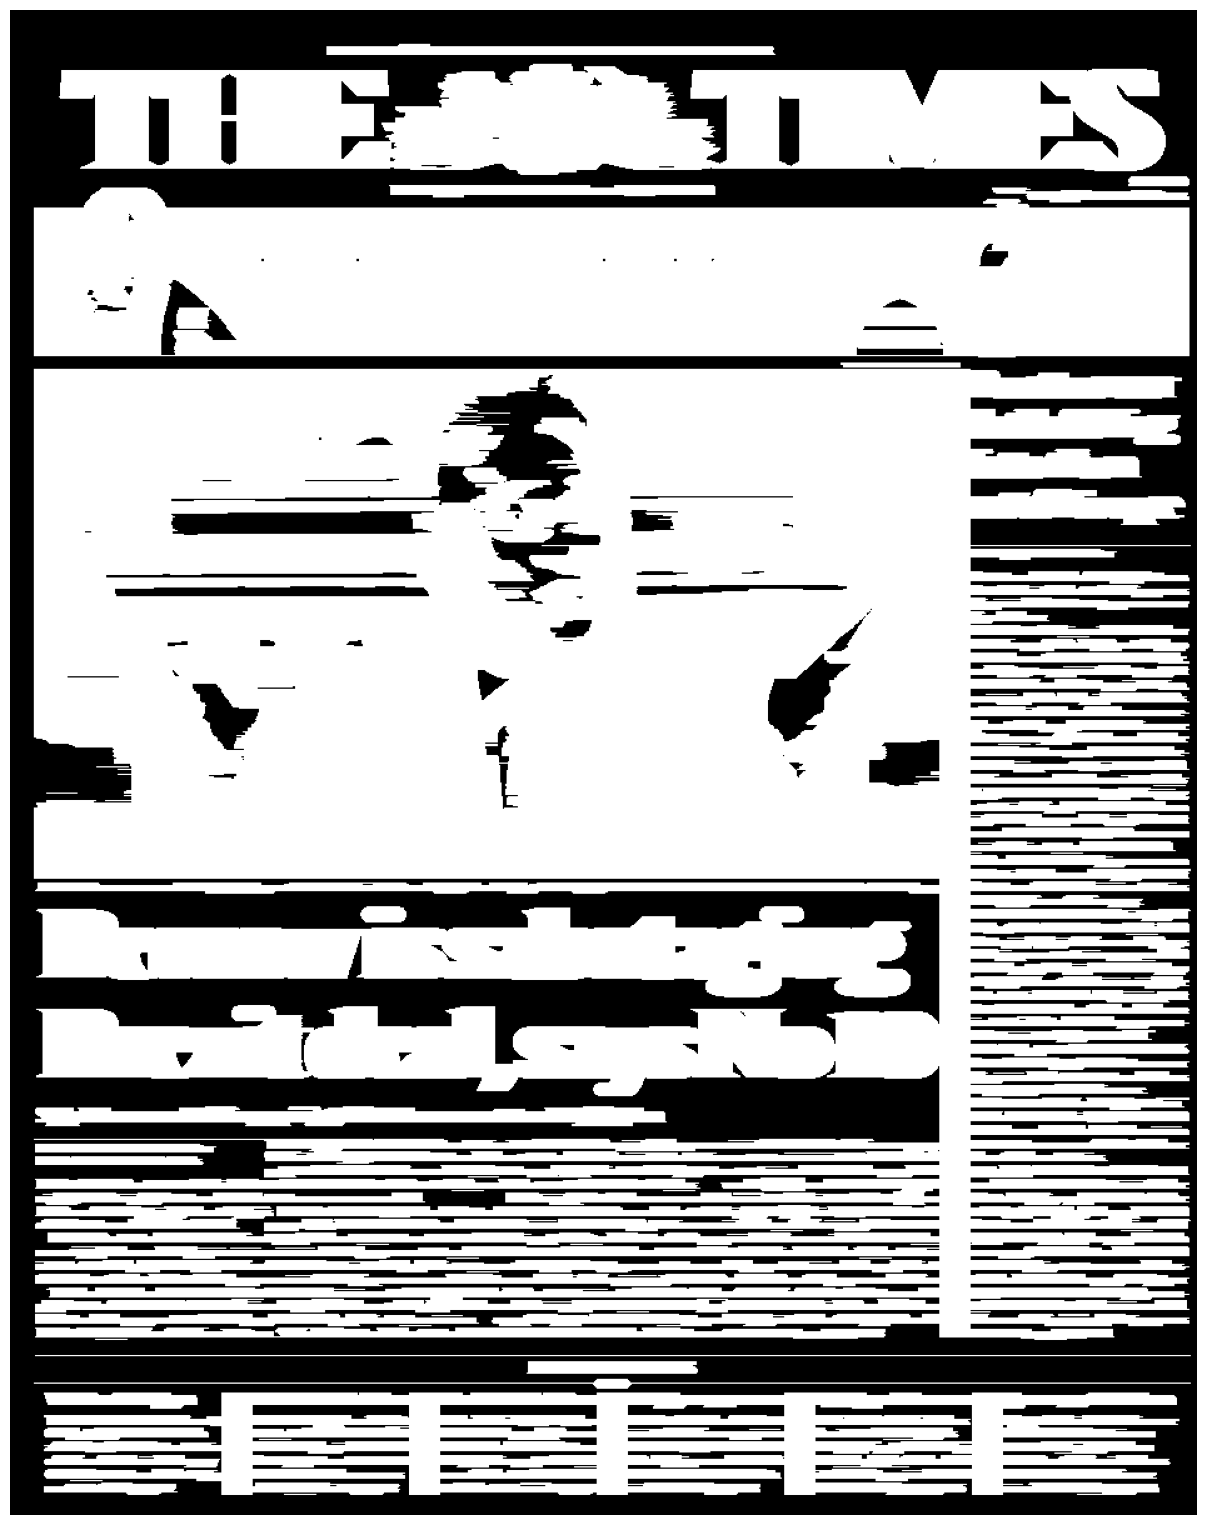

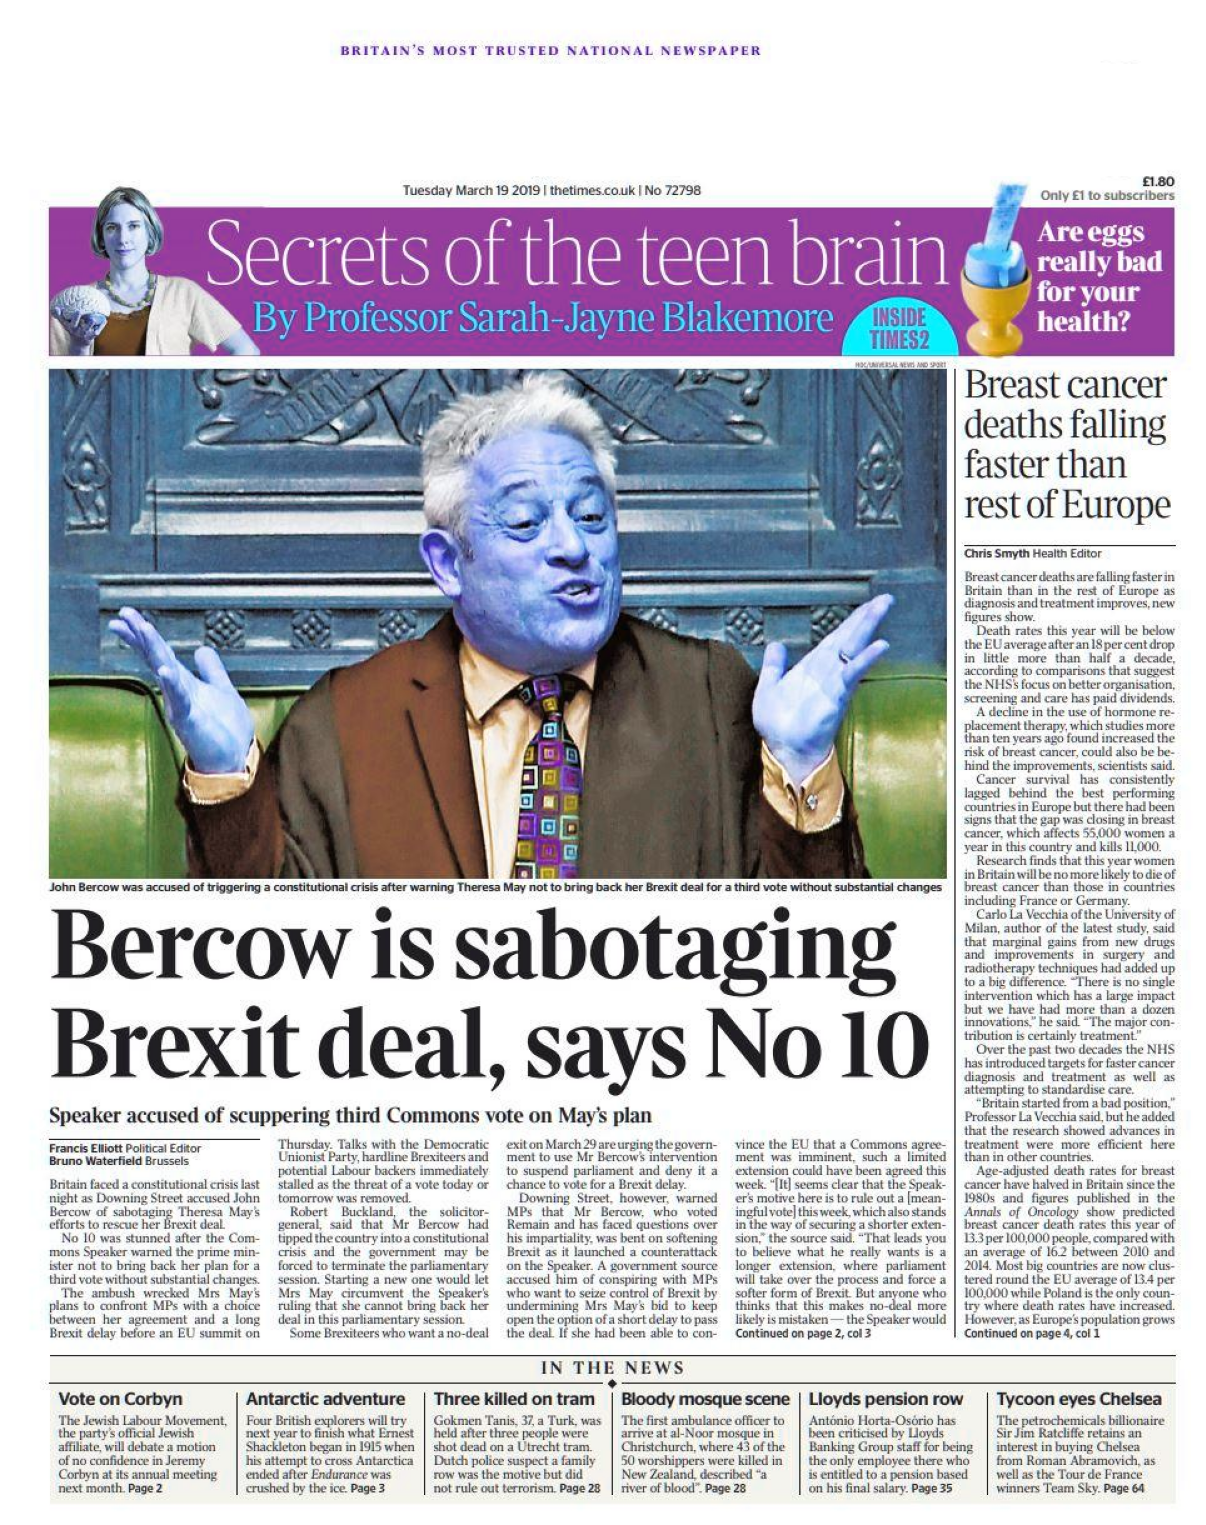

In [9]:
img = remove_top_lines_from_image(img)
display(img)

In [10]:
def desired_text(img):
    results = []
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1,9))
    dilate = cv2.dilate(binary,kernel,iterations=1)
    display(dilate)
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key = lambda x: cv2.boundingRect(x)[0])
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if h > img.shape[0]/7 and w > 30 and y < img.shape[0]/1.14:
            cv2.rectangle(img, (x, y), (x+w, y+h), (36, 255, 12), 2)
            roi = img[y:y+h, x:x+h] # iteratively marking the region to crop them
            ocr_result = pytesseract.image_to_string(roi)
            ocr_result = ocr_result.split("\n")
            for item in ocr_result:
                results.append(item)
    return img, ' '.join(results)

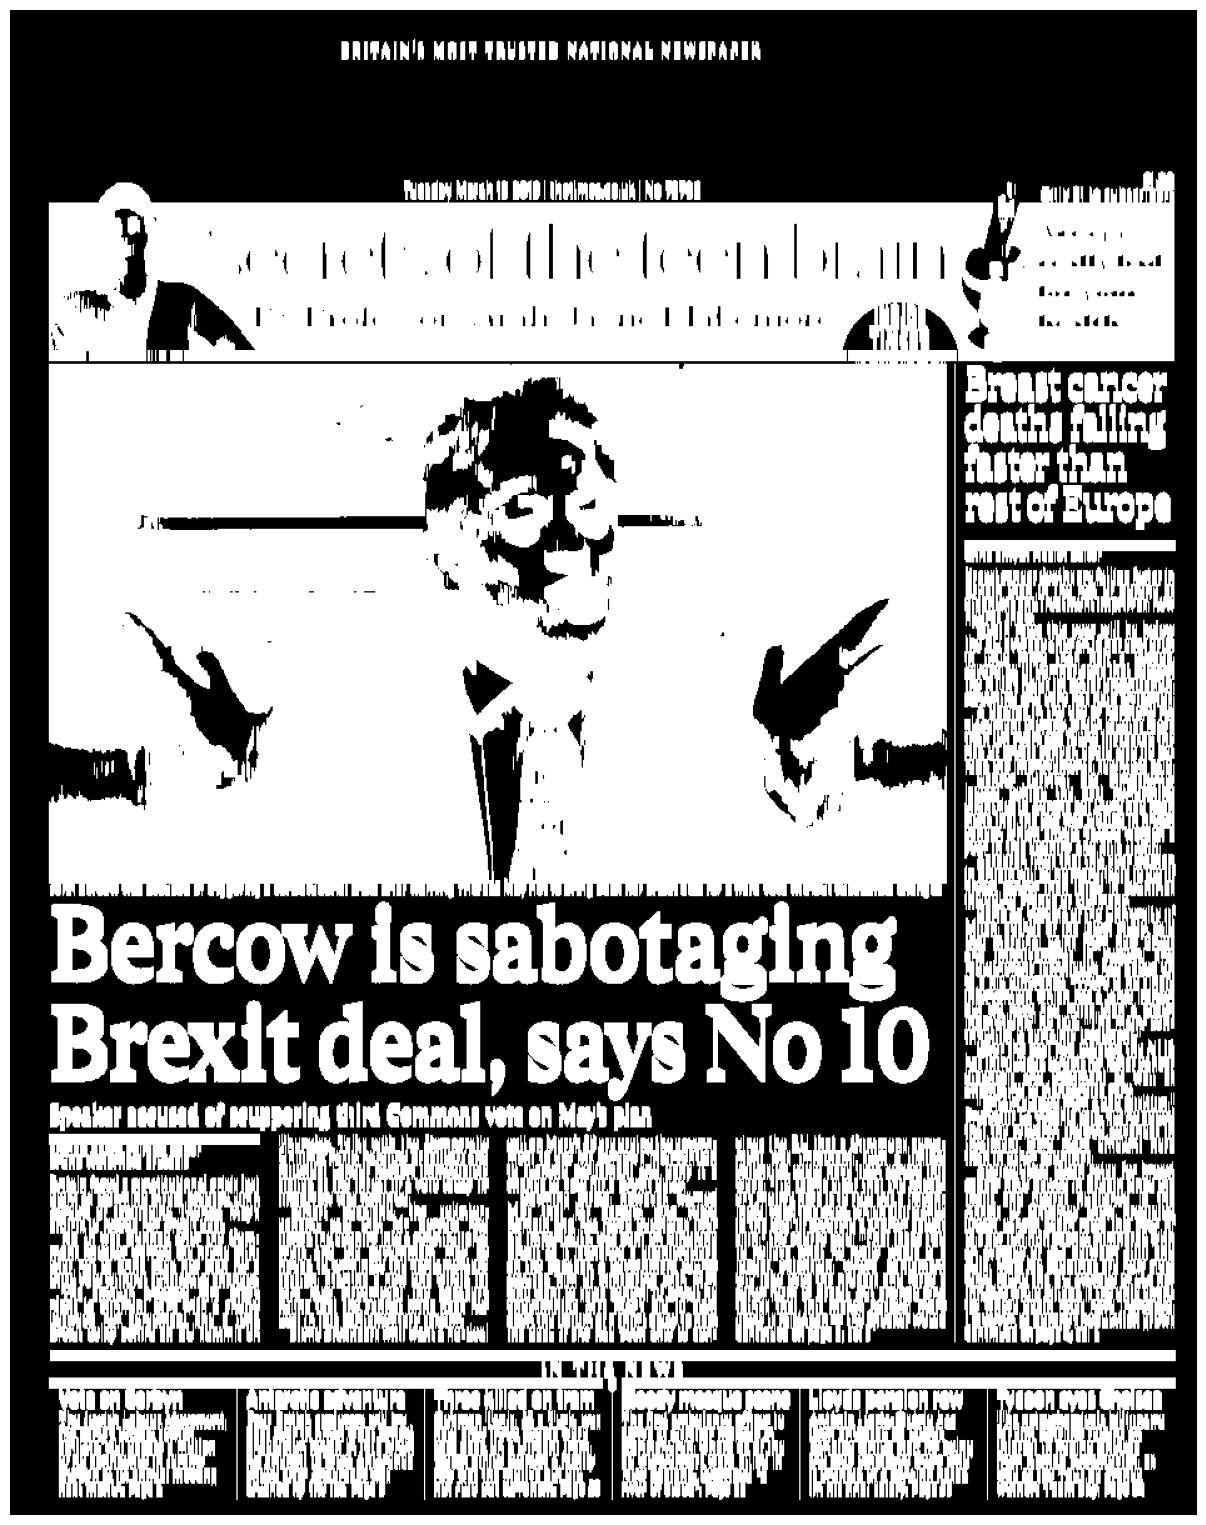

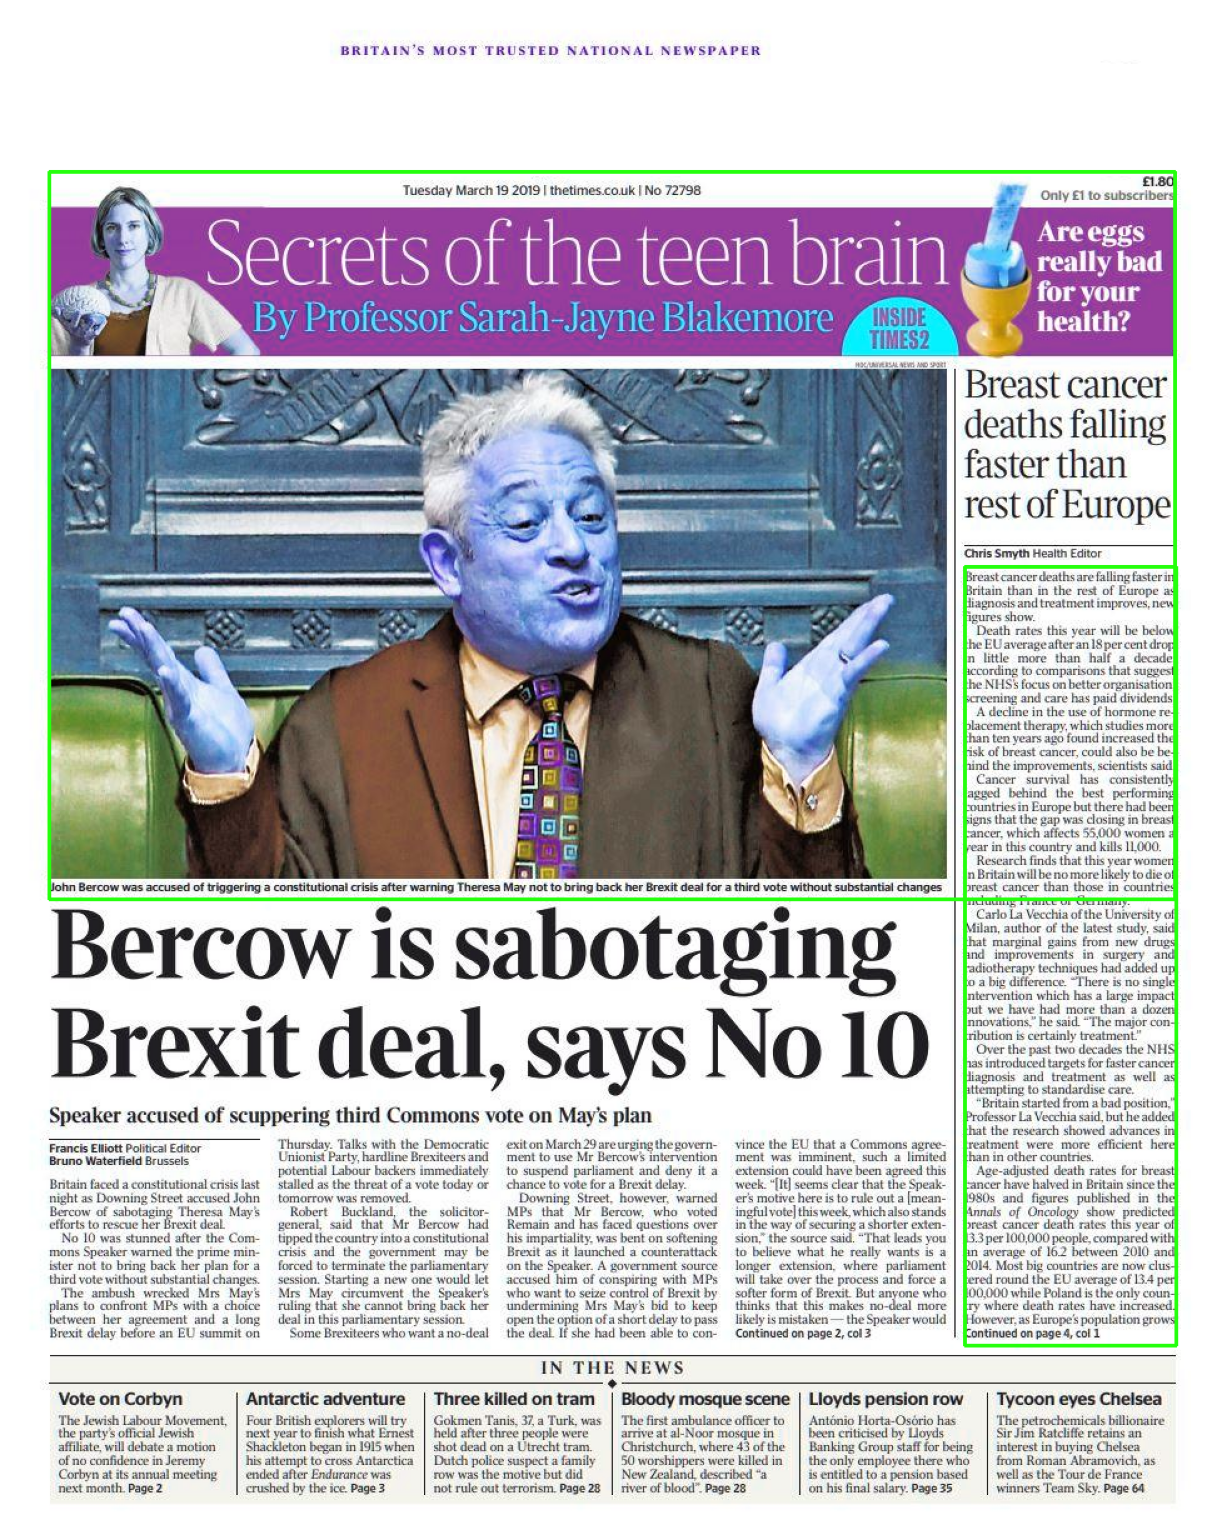

In [11]:
img, text = desired_text(img)
display(img)

In [12]:
text

'Secrets of the teen   jreast cancer deaths are falling faster i tain than in the rest of Europe Hragnosis and treatment improves, igures show.  ‘Death rates this year wil be  intervention which bas large i rat we have had more than a doz snovations" he sad. “The major con  bution i certainly treatment  ‘Over the past to decades the NH has introduced targets for faster cancer figgnosis and treatment a5 well tempting to standardise care  Bitain started from abad position, essr La Veechia said, bute adde hat the research showed advances i eatment were more efficient her amin other countries,  ‘Age-adjusted death rates for bre Lancer have halved in Britain since tn 980s. and figures published in th  nals of Oncology show predict east cancer death rates the ear 5 3per 100,000 people, compared wt  average of 162 between 2010 an  1. Most big countries are now cl ered rund the EU average of 134 pe (00.000 while Poland ste only coun. ry where death rates have increased However. as Europe\'s po

In [13]:
def preprocess_correct_text(text):
    cleaned_text = re.sub(r'\s+', ' ',text).strip()
    blob = TextBlob(text)
    corrected_text = str(blob.correct())
    corrected_text = corrected_text.replace('-','')
    corrected_text = corrected_text.replace('_','')
    corrected_text = corrected_text.replace('#','')
    return corrected_text

In [14]:
text = preprocess_correct_text(text)

# Audio

In [16]:
import pyttsx3

engine = pyttsx3.init()

voices = engine.getProperty('voices')

engine.setProperty('voice', voices[1].id) 

engine.setProperty('rate', 130)    
engine.setProperty('volume', 1) 


engine.say(text)
engine.runAndWait()
